# Semantic Search

This notebook shows hot to make use of pre-trained Transformer models for document embeddings.
These models are trained using *supervised* or *unsupervised* approaches to encode text at sentence-level, paragraph-level or even entire document-level.
They can be applied to many different tasks
- Semantic similarity
- Paraphrase detection
- Natural Langage Inference
- Question Answering
- Information retreival
- Clustering

Most of the material is based on the tuorial and examples on [Sentence Transformers](https://www.sbert.net/docs/)

## Prepare environment

In [25]:
import os
#os.chdir('/content/drive/MyDrive/Colab Notebooks/NLP')
#os.getcwd()

In [26]:
#!pip install -U sentence-transformers
#!pip install datasets
#!pip install hnswlib

In [27]:
from matplotlib import pyplot as plt
%matplotlib inline

## Sentence transformer models

Today we are going to use an extension of the [Transformers library](https://huggingface.co/docs/transformers/index) designed for sentence level analysis (and more): [Sentece Transfromers](https://www.sbert.net) (origianlly known as SenteceBERT or SBERT)

First of all we need to import the sentence transformer and some utilities.

In [28]:
from sentence_transformers import SentenceTransformer, util
import torch

### Embedding text

Let's create an instance of sentence mebedding model based on BERT.
Here you have a list of the available pre-trained models for sentence embedding https://www.sbert.net/docs/pretrained_models.html. 

In [29]:
model = SentenceTransformer('all-mpnet-base-v2')

Let's define a corpus of a few sentences to try out the embedding model

In [30]:
corpus = [
    'A man is eating food.',
    'A man is eating a piece of bread.',
    'The girl is carrying a baby.',
    'A man is riding a horse.',
    'A woman is playing violin.',
    'Two men pushed carts through the woods.',
    'A man is riding a white horse on an enclosed ground.',
    'A monkey is playing drums.',
    'A cheetah is running behind its prey.'
]

We can embed the text in batches with the `encode()` method

In [31]:
corpus_embeddings = model.encode(corpus, convert_to_tensor=True)
corpus_embeddings.size()

torch.Size([9, 768])

Let's give a look at one of the embeddings

In [32]:
corpus_embeddings[0]

tensor([ 3.5501e-02, -8.4316e-03,  2.2024e-02,  1.6263e-02, -5.4016e-03,
         6.8363e-03, -9.6077e-02,  2.6986e-02,  5.4273e-02,  5.4377e-03,
        -6.9691e-03,  1.3709e-03,  2.1613e-02,  9.9688e-03,  6.0931e-03,
         5.6724e-03,  3.1598e-02,  3.0436e-02,  2.3854e-02,  1.6231e-02,
        -3.4623e-02,  5.6503e-03, -9.9568e-04,  1.7790e-02,  3.9526e-03,
         3.6515e-02,  2.7616e-03,  1.0760e-02, -4.3533e-02, -1.6597e-02,
        -5.0252e-02,  3.5208e-03, -4.1181e-02,  2.3466e-02,  1.7661e-06,
         8.1445e-02,  3.6229e-02,  2.0992e-02, -1.3440e-02,  2.1096e-02,
        -2.1274e-02,  3.9456e-03, -8.6086e-03, -4.7137e-02,  1.3027e-02,
         1.4252e-02, -3.1987e-02,  3.5853e-02, -1.7193e-02, -1.3636e-02,
         1.9564e-02, -7.8867e-02, -1.9029e-02,  2.5984e-02, -9.8554e-03,
         4.0118e-02,  4.4400e-02, -1.1126e-02, -8.3517e-03,  4.6718e-02,
         2.1740e-02, -3.3689e-02, -3.0471e-03,  3.4783e-02,  3.8776e-02,
         5.1425e-02,  1.0338e-02,  3.1652e-02,  4.3

### Cosine similarity between embeddings

We can compute the similarity of embedding pairs in our corpus

In [33]:
similarity_matrix = torch.vstack(
    [util.cos_sim(embedding, corpus_embeddings)[0] for embedding in corpus_embeddings]
)
similarity_matrix.size()

torch.Size([9, 9])

And show the similarities in a matrix.
Here the brighter the colour the higher the similarity.

/var/folders/1n/5l6269bd647d957r5df7_hj80000gn/T/ipykernel_22257/2989930838.py:5: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



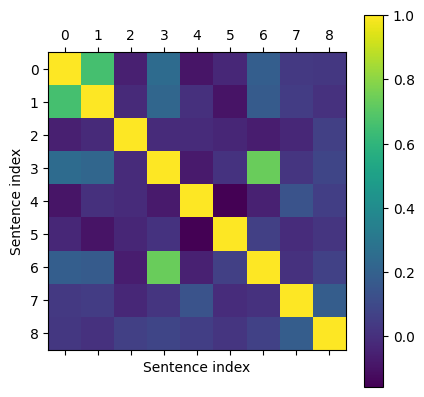

In [34]:
plt.matshow(similarity_matrix.cpu().numpy())
plt.xlabel('Sentence index')
plt.ylabel('Sentence index')
plt.colorbar()
plt.tight_layout()

What do you think of the results? These are the sentences we used

In [35]:
for idx, sentence in enumerate(corpus):
    print(f"{idx}:\t\"{sentence}\"")

0:	"A man is eating food."
1:	"A man is eating a piece of bread."
2:	"The girl is carrying a baby."
3:	"A man is riding a horse."
4:	"A woman is playing violin."
5:	"Two men pushed carts through the woods."
6:	"A man is riding a white horse on an enclosed ground."
7:	"A monkey is playing drums."
8:	"A cheetah is running behind its prey."


On the diagonal we have a perfect match since we are computing the similarity between a piece of text and itself.

### Visualising the embedding space

Ok, looking at lists of numbers is not very useful.
We can try to do some visualisation here.

Let's start by showing the embeddings we computed early.

<Figure size 1000x800 with 0 Axes>

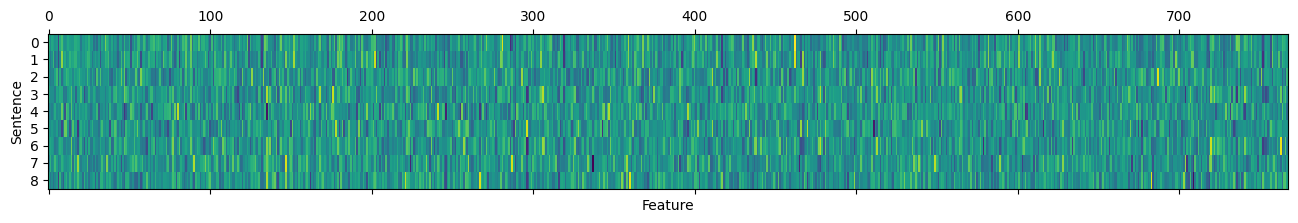

In [36]:
fig = plt.figure(figsize=(10, 8))
plt.matshow(corpus_embeddings.cpu().numpy(), aspect='auto')
plt.xlabel('Feature');
plt.ylabel('Sentence');

Yeah, that's not very informative.

Now let's load a bigger data set so we can learn one of those fancy down-projection like TSNE to visualise the embeddings in a 2D or 3D space.
We can use the sentences in the [SNLI](https://arxiv.org/abs/1508.05326) data set, it is avaialble through the HuggingFace Datasets package (https://huggingface.co/datasets/snli).

In [37]:
import datasets

snli = datasets.load_dataset('snli', split='train')
snli[0]

Found cached dataset snli (/Users/teo/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


{'premise': 'A person on a horse jumps over a broken down airplane.',
 'hypothesis': 'A person is training his horse for a competition.',
 'label': 1}

This data set is used for a task called "Natural Language Inference" (NLI), the task is to recognise the relationship between two sentences: 
- Neutral
- Entailment
- Contradiction

We are just interested in the sentences, so we can drop the structure of the data set.

In [38]:
sentences = list(set(sample[key] for sample in snli for key in ['premise', 'hypothesis']))
len(sentences)

629346

We can embed a subset of these sentences

In [39]:
corpus_embeddings = model.encode(sentences[::300], convert_to_tensor=True).cpu().numpy()
corpus_embeddings.shape

(2098, 768)

Now let's use TSNE to learn a low dimensional representation...

In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, n_iter=500)
tsne_embedding = tsne.fit_transform(corpus_embeddings)

... and plot it in three dimensions

In [41]:
#!pip install plotly

In [42]:
import numpy as np
import plotly.express as px

x, y, z = np.transpose(tsne_embedding)

fig = px.scatter_3d(x=x, y=y, z=z)
fig.update_traces(marker=dict(size=3,line=dict(width=2)))
fig.show()

Now let's select randomly a few sentences to display

In [43]:
# Select ranomly the sentences
embed_idxs = np.random.choice(np.arange(len(tsne_embedding)), 10)
sent_idxs = np.arange(0, len(sentences), 300)[embed_idxs]

# Plot the selected sentences
fig = px.scatter_3d(x=x[embed_idxs], y=y[embed_idxs], z=z[embed_idxs], text=embed_idxs)
fig.update_traces(marker=dict(size=3,line=dict(width=2)))
fig.show()

Let's give a look at the text of the selected sentences

In [44]:
for e_idx, s_idx in zip(embed_idxs, sent_idxs):
    print(f"{e_idx:6d}:\t\"{sentences[s_idx]}\"")

   664:	"Children are studying together, indoors."
  1253:	"A dog leaps high in the air while another watches."
  1095:	"A boy in a torn gray shirt and shorts is photographed from multiple angles as he soars up on a skateboard."
  1820:	"A man sitting indoors"
  1712:	"A man and woman dressed in punk rock style clothing are seen crossing the street during the daytime."
  1683:	"Number 14 and 15 battle it out in a game of water polo."
   879:	"A female athlete is outside."
   519:	"Three workers are on a tractor"
  1774:	"A couple of guys in white t-shirts are leaning over a project."
  1772:	"The tree is falling on the house."


### Multi-lingual models

We have models working with multiple languages, this means we can compute also cross-language similarity

In [45]:
multilingual_model = SentenceTransformer('paraphrase-multilingual-mpnet-base-v2')

Let's pick a sentence and translate it in multiple languages

In [46]:
# multilingual_corpus = [
#     "Where is the library?",
#     "¿Donde está la biblioteca?",
#     "Dov'è la biblioteca?"
# ]
multilingual_corpus = [
    "Io sono Vincenzo Scotti dall'Abruzzo, tu chi sei?",
    "I am Mark Carman and I'm from Australia... Mate!",
    "Sono Mark Carman e vengo dall'Australia... Amico!",
    "Soy Mark Carman y soy de Australia... Compañero!",
    "Ich bin Mark Carman und ich komme aus Australien... Kumpel!"
]

Now let's compute the similarity between translation pairs

In [47]:
for idx, s1 in enumerate(multilingual_corpus):
    for s2 in multilingual_corpus[idx + 1:]:
        s1_embeddings = model.encode(s1, convert_to_tensor=True)
        s2_embeddings = model.encode(s2, convert_to_tensor=True)

        print(f"Sentence 1: \"{s1}\"")
        print(f"Sentence 2: \"{s2}\"")
        print("---------------------------------------------------------------")
        print(f"Cosine similarity: {util.cos_sim(s1_embeddings, s2_embeddings)[0].item():.2f}")
        print("\n\n\n\n")

Sentence 1: "Io sono Vincenzo Scotti dall'Abruzzo, tu chi sei?"
Sentence 2: "I am Mark Carman and I'm from Australia... Mate!"
---------------------------------------------------------------
Cosine similarity: 0.19





Sentence 1: "Io sono Vincenzo Scotti dall'Abruzzo, tu chi sei?"
Sentence 2: "Sono Mark Carman e vengo dall'Australia... Amico!"
---------------------------------------------------------------
Cosine similarity: 0.55





Sentence 1: "Io sono Vincenzo Scotti dall'Abruzzo, tu chi sei?"
Sentence 2: "Soy Mark Carman y soy de Australia... Compañero!"
---------------------------------------------------------------
Cosine similarity: 0.25





Sentence 1: "Io sono Vincenzo Scotti dall'Abruzzo, tu chi sei?"
Sentence 2: "Ich bin Mark Carman und ich komme aus Australien... Kumpel!"
---------------------------------------------------------------
Cosine similarity: 0.27





Sentence 1: "I am Mark Carman and I'm from Australia... Mate!"
Sentence 2: "Sono Mark Carman e vengo dall'Au

## Semantic search

Contextual embedding models allow for semantic search.

We can use the cosine similarity between the embeddings of documents and queries to search through a collection of docuemnts exploting semantics (meaning) rather than syntax.
We can compute the cosine similarity between the embedding of a document and the embedding of a query to compute their matching score.

Altrantively, instead of encoding separately the document and the query, we can learn a model that works on both at the same time and predicts directly the matching score.

### Computing document-query similarity

We can do semantic seach using the cosine similarity between embeddings or we can learn a model predicting directly the matching probability.

#### Cosine similarity search

We can use an encoder model like BERT to extract the emebeddings of two sentences seprately and compare them though cosine similarity. 

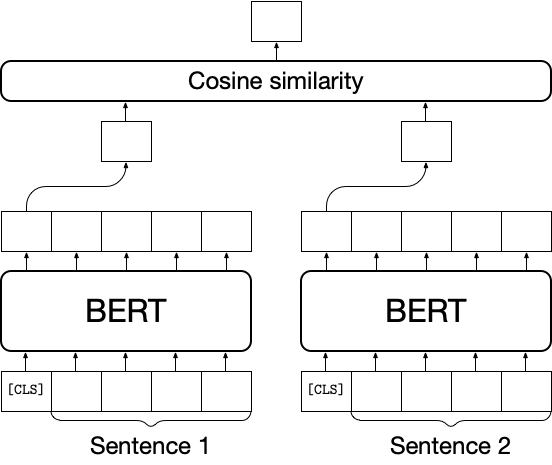

Note that since sentences are encoded separately one from the other, we can pre-compute the embeddings forming some sort of indexed data base and exploit the pre computed embeddings for a later search.

Let's get back at the examples sentence from before and embed them

In [48]:
docs = [
    'A man is eating food.',
    'A man is eating a piece of bread.',
    'The girl is carrying a baby.',
    'A man is riding a horse.',
    'A woman is playing violin.',
    'Two men pushed carts through the woods.',
    'A man is riding a white horse on an enclosed ground.',
    'A monkey is playing drums.',
    'A cheetah is running behind its prey.'
]
docs_embeddings = model.encode(docs, convert_to_tensor=True, device='cpu')

Now we can create a set of queries for semantic similarity

In [49]:
queries = [
    'A man is eating pasta.', 
    'Someone in a gorilla costume is playing a set of drums.', 
    'A cheetah chases prey on across a field.'
]

Let's find the closest 5 sentences of the corpus for each query sentence based on cosine similarity

In [50]:
# Let's set the maximum number of matches to retrieve
top_k = min(5, len(corpus))
# Iterate over queries
for query in queries:
    # Embed query
    query_embedding = model.encode(query, convert_to_tensor=True)
    # Use cosine-similarity and torch.topk to find the highest 5 scores
    cos_scores = util.cos_sim(query_embedding, docs_embeddings)[0]
    top_results = torch.topk(cos_scores, k=top_k)
    # Print the result
    print(f"Query: \"{query}\"")
    print("Top 5 most similar sentences in corpus:")
    print("---------------------------------------")
    for score, idx in zip(top_results[0], top_results[1]):
        print(f"Score: {score:.2f} - Document: \"{corpus[idx]}\"")
    print("\n\n\n\n")

Query: "A man is eating pasta."
Top 5 most similar sentences in corpus:
---------------------------------------
Score: 0.59 - Document: "A man is eating food."
Score: 0.42 - Document: "A man is eating a piece of bread."
Score: 0.19 - Document: "A man is riding a horse."
Score: 0.10 - Document: "A man is riding a white horse on an enclosed ground."
Score: 0.01 - Document: "A cheetah is running behind its prey."





Query: "Someone in a gorilla costume is playing a set of drums."
Top 5 most similar sentences in corpus:
---------------------------------------
Score: 0.64 - Document: "A monkey is playing drums."
Score: 0.18 - Document: "A cheetah is running behind its prey."
Score: 0.12 - Document: "A woman is playing violin."
Score: 0.08 - Document: "A man is riding a white horse on an enclosed ground."
Score: 0.07 - Document: "A man is eating food."





Query: "A cheetah chases prey on across a field."
Top 5 most similar sentences in corpus:
---------------------------------------
Scor

Alternatively, we can use the built in function for semantic search that computes automatically all the query-document similarity pairs

In [51]:
query_embeddings = model.encode(queries, convert_to_tensor=True)

util.semantic_search(query_embeddings, docs_embeddings, score_function=util.cos_sim)

[[{'corpus_id': 0, 'score': 0.589895486831665},
  {'corpus_id': 1, 'score': 0.42187610268592834},
  {'corpus_id': 3, 'score': 0.19115908443927765},
  {'corpus_id': 6, 'score': 0.09997967630624771},
  {'corpus_id': 8, 'score': 0.00801362469792366},
  {'corpus_id': 7, 'score': -0.018896466121077538},
  {'corpus_id': 4, 'score': -0.021399252116680145},
  {'corpus_id': 2, 'score': -0.02980889193713665},
  {'corpus_id': 5, 'score': -0.11770573258399963}],
 [{'corpus_id': 7, 'score': 0.6435328722000122},
  {'corpus_id': 8, 'score': 0.17746494710445404},
  {'corpus_id': 4, 'score': 0.11836573481559753},
  {'corpus_id': 6, 'score': 0.08056438714265823},
  {'corpus_id': 0, 'score': 0.07234098017215729},
  {'corpus_id': 3, 'score': 0.038123078644275665},
  {'corpus_id': 1, 'score': 0.0186957698315382},
  {'corpus_id': 5, 'score': -0.01123350951820612},
  {'corpus_id': 2, 'score': -0.062058184295892715}],
 [{'corpus_id': 8, 'score': 0.8002290725708008},
  {'corpus_id': 6, 'score': 0.1632097065448

#### Speed up cosine similarity

We can speed-up the process by pre-nomalising the embeddings and compute directly the dot-product instead of cosine similarity.

In [52]:
normlaised_docs_embeddings = util.normalize_embeddings(model.encode(docs, convert_to_tensor=True))
normalised_query_embeddings = util.normalize_embeddings(model.encode(queries, convert_to_tensor=True))

In [53]:
hits = util.semantic_search(normalised_query_embeddings, normlaised_docs_embeddings, score_function=util.dot_score)
hits

[[{'corpus_id': 0, 'score': 0.589895486831665},
  {'corpus_id': 1, 'score': 0.42187610268592834},
  {'corpus_id': 3, 'score': 0.19115908443927765},
  {'corpus_id': 6, 'score': 0.09997967630624771},
  {'corpus_id': 8, 'score': 0.00801362469792366},
  {'corpus_id': 7, 'score': -0.018896466121077538},
  {'corpus_id': 4, 'score': -0.021399252116680145},
  {'corpus_id': 2, 'score': -0.02980889193713665},
  {'corpus_id': 5, 'score': -0.11770573258399963}],
 [{'corpus_id': 7, 'score': 0.6435328722000122},
  {'corpus_id': 8, 'score': 0.17746494710445404},
  {'corpus_id': 4, 'score': 0.11836573481559753},
  {'corpus_id': 6, 'score': 0.08056438714265823},
  {'corpus_id': 0, 'score': 0.07234098017215729},
  {'corpus_id': 3, 'score': 0.038123078644275665},
  {'corpus_id': 1, 'score': 0.0186957698315382},
  {'corpus_id': 5, 'score': -0.01123350951820612},
  {'corpus_id': 2, 'score': -0.062058184295892715}],
 [{'corpus_id': 8, 'score': 0.8002290725708008},
  {'corpus_id': 6, 'score': 0.1632097065448

#### Cross-encoder

Cross encoder models work by encoding together the sentences in a pair or a document-query pair.

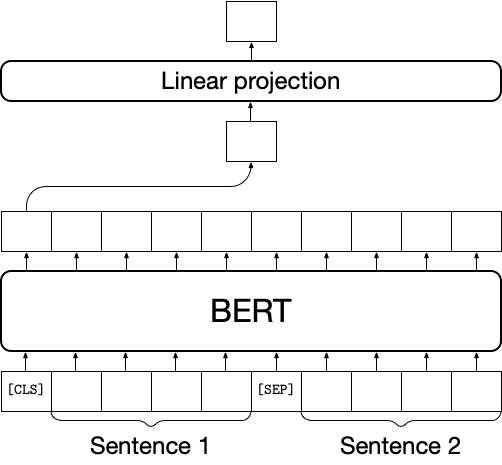

Differently from the previous models that can be trained either with a supervised approach or with an unsupervised appraoch, in this case they only work if trained for some supervised target like classification (e.g., paraphrase detection) or regression (e.g., sentence similarity).

Let's load a cross-encoder model

In [54]:
from sentence_transformers import CrossEncoder

model = CrossEncoder('cross-encoder/stsb-distilroberta-base')

Let's use this model to compute the similarity between the queries and the documents

In [55]:
import numpy as np

# Iterate over queries
for query in queries:
    # Prepare model inputs 
    model_inputs = [[query, doc] for doc in docs]
    # Predict similarity score
    scores = model.predict(model_inputs)
    # Print the result
    print(f"Query: \"{query}\"")
    print("---------------------------------------")
    for idx in np.argsort(-scores):
        print(f"Score: {scores[idx]:.4f} - Document: \"{corpus[idx]}\"")
    print("\n\n\n\n")

Query: "A man is eating pasta."
---------------------------------------
Score: 0.6732 - Document: "A man is eating food."
Score: 0.3410 - Document: "A man is eating a piece of bread."
Score: 0.0757 - Document: "A man is riding a horse."
Score: 0.0668 - Document: "A man is riding a white horse on an enclosed ground."
Score: 0.0054 - Document: "The girl is carrying a baby."
Score: 0.0054 - Document: "Two men pushed carts through the woods."
Score: 0.0053 - Document: "A monkey is playing drums."
Score: 0.0053 - Document: "A woman is playing violin."
Score: 0.0052 - Document: "A cheetah is running behind its prey."





Query: "Someone in a gorilla costume is playing a set of drums."
---------------------------------------
Score: 0.5655 - Document: "A monkey is playing drums."
Score: 0.0832 - Document: "A woman is playing violin."
Score: 0.0206 - Document: "A cheetah is running behind its prey."
Score: 0.0060 - Document: "Two men pushed carts through the woods."
Score: 0.0057 - Document: "

### Question answering pipeline

Ok this is cool (I know you think it is cool, I can read your minds), but what can we do when we have a large data set and complex applications like question answering?
Let's try out!

The following example is based on this one https://github.com/UKPLab/sentence-transformers/blob/master/examples/applications/retrieve_rerank/retrieve_rerank_simple_wikipedia.ipynb

Let's start by loading a sentence embedding model and a cross encoder model

In [56]:
from sentence_transformers import SentenceTransformer, CrossEncoder, util

semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

#### Prepare data

We can load a reduced copy of Wikipedia ([Simple Wikipedia](https://simple.wikipedia.org/wiki/Main_Page), which is different from Simple Jack from Tropic Thunder 😬).



Let's start by downloading the data set if it is not avaialble

In [57]:
import os

wikipedia_filepath = 'simplewiki-2020-11-01.jsonl.gz'
if not os.path.exists(wikipedia_filepath):
    util.http_get('http://sbert.net/datasets/simplewiki-2020-11-01.jsonl.gz', wikipedia_filepath)

100%|██████████| 50.2M/50.2M [00:01<00:00, 38.5MB/s]


Now let's load the first paragraph of each document

In [58]:
import json
import gzip

passages = []
# Open the file with the dump of Simple Wikipedia
with gzip.open(wikipedia_filepath, 'rt', encoding='utf8') as f:
    # Iterate over the lines
    for line in f:
        # Parse the document using JSON
        data = json.loads(line.strip())
        # Add all paragraphs
        #passages.extend(data['paragraphs'])
        # Only add the first paragraph
        passages.append(data['paragraphs'][0])

print(f"Retreived {len(passages)} passages")

Retreived 169597 passages


Now we can embed the retrieved passaged using the sentence embedding model

In [ ]:
corpus_embeddings = semb_model.encode(passages, convert_to_tensor=True, show_progress_bar=True)

#### Approximated Nearest Neighbor search

When we use an embedding model with cosine similarity, we can pre-compute the embeddings in our data set and index them to speed-up the search.
There are techniques for Approximate Nearest Neighbor (ANN), which use clustering to index the embedding space and speed-up the search process.

Note that this is not applicable to cross-encoder models, which encode document and query together.

Sentence transformers support different libraries for ANN:
- [HNSWLIB](https://github.com/nmslib/hnswlib/)
- [Annoy](https://github.com/spotify/annoy)
- [FAISS](https://github.com/spotify/annoy)

Let's try indexing with **HNSWLIB** (yes yes I know, do or do not, there is not try...)

Import the HNSWLIB library and create and empty index

In [ ]:
import hnswlib

index = hnswlib.Index(space='cosine', dim=corpus_embeddings.size(1))

Now we can index our data. The index we compute can be saved and loaded, so we can check if it is already availabel and load it (this will save time)

In [ ]:
import os

# Define hnswlib index path
index_path = "./hnswlib.index"

# Load index if available
if os.path.exists(index_path):
    print("Loading index...")
    index.load_index(index_path)
# Else index data collection
else:
    # Initialise the index
    print("Start creating HNSWLIB index")
    index.init_index(max_elements=corpus_embeddings.size(0), ef_construction=400, M=64)
    #  Compute the HNSWLIB index (it may take a while)
    index.add_items(corpus_embeddings.cpu(), list(range(len(corpus_embeddings))))
    # Save the index to a file for future loading
    print("Saving index to:", index_path)
    index.save_index(index_path)

Start creating HNSWLIB index
Saving index to: ./hnswlib.index


Is it really faster to search? Let's see.

We can create a query

In [ ]:
query = "Why is it that the plural of finger is fingers and not hand?"
query_embedding = semb_model.encode(query, convert_to_tensor=True)

And measure the running time

In [ ]:
from datetime import datetime

# Search using index
t_start = datetime.now()
_ = index.knn_query(query_embedding.cpu(), k=128)
t_stop = datetime.now()
print(f"Search time with index: {t_stop - t_start}")

# Search without index
t_start = datetime.now()
_ = util.semantic_search(query_embedding, corpus_embeddings, score_function=util.cos_sim, top_k=128)
t_stop = datetime.now()
print(f"Search time without index: {t_stop - t_start}")

Search time with index: 0:00:00.003077
Search time without index: 0:00:00.005909


### Re-ranking

Cross-encoder models empirically yield better results, but are slow at inference.
Embedding models with cosine similarity, on the other side, are less precise, but are also faster at inference.

We can take advantage of both: We can do a first search with bi-encoder models and then re-rank the top-$k$ results with a cross-encoder.
We call this approach *retrieve and re-rank*.

Let's use the ANN index we just computed and a cross encoder model to build a retrieval pipeline

Define a query

In [ ]:
query = "Which is the capital of the United States?"
query_embedding = semb_model.encode(query, convert_to_tensor=True)

Search using ANN index

In [ ]:
corpus_ids, distances = index.knn_query(query_embedding.cpu(), k=3)
scores = 1 - distances

print("Cosine similarity model search results")
print(f"Query: \"{query}\"")
print("---------------------------------------")
for idx, score in zip(corpus_ids[0], scores[0]):
    print(f"Score: {score:.4f}\nDocument: \"{passages[idx]}\"\n\n")

Cosine similarity model search results
Query: "Which is the capital of the United States?"
---------------------------------------
Score: 0.6216
Document: "Cities in the United States:"


Score: 0.6067
Document: "The United States Capitol is the building where the United States Congress meets. It is the center of the legislative branch of the U.S. federal government. It is in Washington, D.C., on top of Capitol Hill at the east end of the National Mall."


Score: 0.5744
Document: "Washington, D.C. (also known as simply Washington or D.C., and officially as the District of Columbia) is the capital of the United States. It is a federal district. The President of the USA and many major national government offices are in the territory. This makes it the political center of the United States of America."




Let's add the re-ranking

In [ ]:
corpus_ids, _ = index.knn_query(query_embedding.cpu(), k=128)

model_inputs = [(query, passages[idx]) for idx in corpus_ids[0]]
cross_scores = xenc_model.predict(model_inputs)

print("Cross-encoder model re-ranking results")
print(f"Query: \"{query}\"")
print("---------------------------------------")
for idx in np.argsort(-cross_scores)[:3]:
    print(f"Score: {cross_scores[idx]:.4f}\nDocument: \"{passages[corpus_ids[0][idx]]}\"\n\n")

Cross-encoder model re-ranking results
Query: "Which is the capital of the United States?"
---------------------------------------
Score: 9.3665
Document: "Washington, D.C. (also known as simply Washington or D.C., and officially as the District of Columbia) is the capital of the United States. It is a federal district. The President of the USA and many major national government offices are in the territory. This makes it the political center of the United States of America."


Score: 4.1543
Document: "The continental United States is the area of the United States of America that is located in the continent of North America. It includes 49 of the 50 states (48 of which are located south of Canada and north of Mexico, known as the "lower 48 states", the other being Alaska) and the District of Columbia, which contains the federal capital, Washington, D.C. The only state which is not part of this is Hawaii (as they are islands in the Pacific Ocean and not part of North America)."


Score:

Try out other queries

In [ ]:
query = "What is the best orchestra in the world?"
query_embedding = semb_model.encode(query, convert_to_tensor=True)

corpus_ids, _ = index.knn_query(query_embedding.cpu(), k=128)

model_inputs = [(query, passages[idx]) for idx in corpus_ids[0]]
cross_scores = xenc_model.predict(model_inputs)

print("Cross-encoder model re-ranking results")
print(f"Query: \"{query}\"")
print("---------------------------------------")
for idx in np.argsort(-cross_scores)[:3]:
    print(f"Score: {cross_scores[idx]:.4f}\nDocument: \"{passages[corpus_ids[0][idx]]}\"\n\n")

Cross-encoder model re-ranking results
Query: "What is the best orchestra in the world?"
---------------------------------------
Score: 5.9522
Document: "The London Symphony Orchestra (LSO) is one of the most famous orchestras of the world. They are based in London's Barbican Centre, but they often tour to lots of different countries."


Score: 5.7941
Document: "The Vienna Philharmonic (in German: die Wiener Philharmoniker) is an orchestra based in Vienna, Austria. It is thought of as one of the greatest orchestras in the world."


Score: 5.3239
Document: "The Berlin Philharmonic (in German: Die Berliner Philharmoniker), is an orchestra from Berlin, Germany. It is one of the greatest orchestras in the world. The conductor of the orchestra is Sir Simon Rattle."




In [ ]:
query = "Number countries Europe"
query_embedding = semb_model.encode(query, convert_to_tensor=True)

corpus_ids, _ = index.knn_query(query_embedding.cpu(), k=128)

model_inputs = [(query, passages[idx]) for idx in corpus_ids[0]]
cross_scores = xenc_model.predict(model_inputs)

print("Cross-encoder model re-ranking results")
print(f"Query: \"{query}\"")
print("---------------------------------------")
for idx in np.argsort(-cross_scores)[:3]:
    print(f"Score: {cross_scores[idx]:.4f}\nDocument: \"{passages[corpus_ids[0][idx]]}\"\n\n")

Cross-encoder model re-ranking results
Query: "Number countries Europe"
---------------------------------------
Score: 5.1992
Document: "The European Union (abbreviation: EU) is a confederation of 27 member countries in Europe established by the Maastricht Treaty in 1992-1993. The EU grew out of the European Economic Community (EEC) which was established by the Treaties of Rome in 1957. It has created a common economic area with Europe-wide laws allowing the citizens of EU countries to move and trade in other EU countries almost the same as they do in their own. Nineteen of these countries also share the same type of money: the euro."


Score: 3.2021
Document: "A European Union member state is any one of the twenty-seven countries that have joined the European Union (EU) since it was found in 1958 as the European Economic Community (EEC). From an original membership of six states, there have been five successive enlargements. The largest happened on 1 May 2004, when ten member states j

In [ ]:
query = "When did the cold war end?"
query_embedding = semb_model.encode(query, convert_to_tensor=True)

corpus_ids, _ = index.knn_query(query_embedding.cpu(), k=128)

model_inputs = [(query, passages[idx]) for idx in corpus_ids[0]]
cross_scores = xenc_model.predict(model_inputs)

print("Cross-encoder model re-ranking results")
print(f"Query: \"{query}\"")
print("---------------------------------------")
for idx in np.argsort(-cross_scores)[:3]:
    print(f"Score: {cross_scores[idx]:.4f}\nDocument: \"{passages[corpus_ids[0][idx]]}\"\n\n")

Cross-encoder model re-ranking results
Query: "When did the cold war end?"
---------------------------------------
Score: 5.2034
Document: "The Cold War was the tense relationship between the United States (and its allies), and the Soviet Union (the USSR and its allies) between the end of World War II and the fall of the Soviet Union. It is called the "Cold" War because the US and the USSR never actually fought each other directly. Instead, they opposed each other in conflicts known as proxy wars, where each country chose a side to support."


Score: 2.5311
Document: "A speech was made by American President Harry S. Truman to the U.S. Congress on 12 March 1947. In this speech he said he thought that The United States should help Greece and Turkey to stop them being 'Totalitarianists' although he meant Soviet Communism. This became known as the Truman Doctrine. Some Historians believe that this was the start of the Cold War."


Score: 2.0793
Document: "The Sino-Soviet split (1960–1989) 

## Retrieval-based chatbots

During the lectures you have started getting familiar with *chabots* (open-domain conversational agents).

We can use these semantic search pipelines to build a retrieval-based chatbot.
It is a data-driven kind of chatbot that gets responses from a data set.

We can use the same retreive and re-rank pipeline from before, let's start by importing the models.


In [ ]:
from sentence_transformers import SentenceTransformer, CrossEncoder, util

semb_model = SentenceTransformer('multi-qa-MiniLM-L6-cos-v1')
xenc_model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

We are going to use a slightly different appraoch.
1. First we are going to rank by similarity of the last user sentence and the sentences in out corpus (the initial matches).
2. Then we we are going to extract the response to the matches in our data set. Intuitively, semantic similarity gives us a sentence that is similar to the query one, so we want to get the responses to to a possible match.
3. We are going to re-rank the user-message and retreived-response pairs

### Dialogue data

For this part we are going to use the [EmpatheticDialogues](https://arxiv.org/pdf/1811.00207.pdf) data set, again available via the HuggingFace datasets library

#### Load 

Let's start by loading our data set. 
For simplicity we are going to use only the validation set.

In [ ]:
import datasets

empdialogues = datasets.load_dataset('empathetic_dialogues', split='train')
empdialogues[:3]

Generating train split:   0%|          | 0/76673 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/12030 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10943 [00:00<?, ? examples/s]

Dataset empathetic_dialogues downloaded and prepared to /root/.cache/huggingface/datasets/empathetic_dialogues/default/0.1.0/09bbeed3882a67db98c73952fb3c1c9a85af83dc78f81454c2454382fd03f6cf. Subsequent calls will reuse this data.


{'conv_id': ['hit:0_conv:1', 'hit:0_conv:1', 'hit:0_conv:1'],
 'utterance_idx': [1, 2, 3],
 'context': ['sentimental', 'sentimental', 'sentimental'],
 'prompt': ['I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.',
  'I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.',
  'I remember going to the fireworks with my best friend. There was a lot of people_comma_ but it only felt like us in the world.'],
 'speaker_idx': [1, 0, 1],
 'utterance': ['I remember going to see the fireworks with my best friend. It was the first time we ever spent time alone together. Although there was a lot of people_comma_ we felt like the only people in the world.',
  'Was this a friend you were in love with_comma_ or just a best friend?',
  'This was a best friend. I miss her.'],
 'selfeval': ['5|5|5_2|2|5', '5|5|5_2|2|5', '5|5|5_2|2|5'],
 'tags': ['', '', ''

Now we need to build all the message-response pairs.

We start by grouping together the utterances (turns) that belong to the same dialogue.
First we convert the data set to a Pandas DataFrame

In [ ]:
import pandas as pd

df = pd.DataFrame(empdialogues)
df

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
0,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,
1,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,
2,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,
3,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,
4,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,
...,...,...,...,...,...,...,...,...
76668,hit:12424_conv:24848,5,sentimental,I found some pictures of my grandma in the att...,389,Yeah reminds me of the good old days. I miss ...,5|5|5_5|5|5,
76669,hit:12424_conv:24849,1,surprised,I woke up this morning to my wife telling me s...,294,I woke up this morning to my wife telling me s...,5|5|5_5|5|5,
76670,hit:12424_conv:24849,2,surprised,I woke up this morning to my wife telling me s...,389,Oh hey that's awesome! That is awesome right?,5|5|5_5|5|5,
76671,hit:12424_conv:24849,3,surprised,I woke up this morning to my wife telling me s...,294,It is soooo awesome. We have been wanting a b...,5|5|5_5|5|5,


Now we can goup the samples and go through individual dialogues to build the pairs

In [ ]:
data_pairs = []
# Iterate over dialogues
for _, dialogue_df in df.groupby('conv_id', sort=False):
    # Extract utterances text
    uttrances = dialogue_df['utterance'].values
    # Iterarte over pairs
    for message, response in zip(uttrances[:-1], uttrances[1:]):
        # Add pair to collection
        data_pairs.append(
            {'message': message.replace('_comma_', ','), 'response': response.replace('_comma_', ',')}
        )

len(data_pairs)

58829

#### Index

Now we can embed the messages in our data set

In [ ]:
corpus_embeddings = semb_model.encode([sample['message'] for sample in data_pairs], convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/1839 [00:00<?, ?it/s]

And we can build an ANN index to do a quick cosine similarity search

In [ ]:
import os
import hnswlib

# Create empty index
hnswlib_index = hnswlib.Index(space='cosine', dim=corpus_embeddings.size(1))

# Define hnswlib index path
index_path = "./emp_dialogue_hnswlib.index"

# Load index if available
if os.path.exists(index_path):
    print("Loading index...")
    hnswlib_index.load_index(index_path)
# Else index data collection
else:
    # Initialise the index
    print("Start creating HNSWLIB index")
    hnswlib_index.init_index(max_elements=corpus_embeddings.size(0), ef_construction=400, M=64)
    #  Compute the HNSWLIB index (it may take a while)
    hnswlib_index.add_items(corpus_embeddings.cpu(), list(range(len(corpus_embeddings))))
    # Save the index to a file for future loading
    print("Saving index to:", index_path)
    hnswlib_index.save_index(index_path)

Start creating HNSWLIB index
Saving index to: ./emp_dialogue_hnswlib.index


### Search for response

We are going to search for a response in the following way:
1. Search for a similar message to the latest user input.
2. Retrieve response associated to the message.
2. Re-rank possible responses.

#### Retrieval function

Let's define a response function

In [ ]:
import numpy as np

def get_response(message, mes_resp_pairs, index, re_ranking_model=None, top_k=32):
    message_embedding = semb_model.encode(message, convert_to_tensor=True).cpu()

    corpus_ids, _ = index.knn_query(message_embedding, k=top_k)

    model_inputs = [(message, mes_resp_pairs[idx]['response']) for idx in corpus_ids[0]]
    cross_scores = xenc_model.predict(model_inputs)

    idx = np.argsort(-cross_scores)[0]

    return mes_resp_pairs[corpus_ids[0][idx]]['response']

Note that the use of re-ranking is optional (you can pass a none `re_ranking_model`) and the top results to re-score are configurable. 
You can play a bit with these hyperaparameters to see how responses change.

Let's try out the retreival function

In [ ]:
chatbot_response = get_response(
    "I like going out with my puppies.", data_pairs, hnswlib_index, re_ranking_model=xenc_model
)
chatbot_response

"Awesome, I bet you're with your puppy all the time now :)"

#### Conversation loop 

Let's try chatting with our retreival system

In [ ]:
# Initialise dialogue history
dialogue_history = ["Hello, how are you?"]

# Start chatting
print("Press [Ctrl-C] to stop\n\n\n\n")
print(f"Chatbot: {dialogue_history[0]}")
# Keep talking until stop
running = True
while running:
    try:
        # Read user message
        user_message = input("User: ")
        # Append message to dialogue history
        dialogue_history.append(user_message)
        # Search for a chatbot response
        chatbot_response = get_response(
            user_message, data_pairs, hnswlib_index, re_ranking_model=xenc_model
        )
        # Append chatbot response to dialogue history
        dialogue_history.append(chatbot_response)
        # Print chatbot response
        print(f"Chatbot: {chatbot_response}")
    except KeyboardInterrupt:
        running = False

Press [Ctrl-C] to stop




Chatbot: Hello, how are you?
User: I'm sad, my dog died yesterday...
Chatbot: Man, that is so sad.  I don't know what I would do if my dog ran away!  Did you ever find him?
